# Baseline Fit to Taxi Dataset

This is a copy of `data_processing/01_d_basic_ts_model.ipynb`, modified using the modified taxi data.

### load packages

In [4]:
import sys, os
sys.path.append('..') # add parent directory to path

import numpy as np 
import pandas as pd
from utils import processing as pr
import matplotlib.pyplot as plt
import seaborn as sns

### Load Test Data from Previous Notebook (03_combine_datasets.ipynb)
Consider only pickups from Taxi Zone 79 (East Village)

<Axes: xlabel='pickup_datetime'>

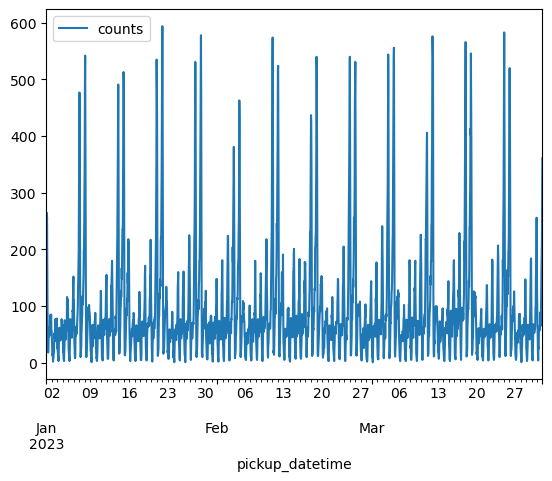

In [5]:
# load data
ts = pd.read_pickle('../../processed_taxi_data/adjusted_yellow_2023-01_2023-03_bypulocation.pkl')

# taxi zone 79
ts_1 = ts[ts['PULocationID'] == 79]
ts_1.plot(x = 'pickup_datetime', y = 'counts')

In [6]:
# basic processing
ts_1.drop(columns = ['PULocationID'], inplace = True) # PULocationID is constant, drop it
ts_1.set_index('pickup_datetime', inplace = True) # time series model packages require datetime index

/tmp/ipykernel_2123/2417320451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_1.drop(columns = ['PULocationID'], inplace = True) # PULocationID is constant, drop it


### Assessing Seasonality of Data
First, let's consider just three weeks of data.

(464592.0, 465240.0)

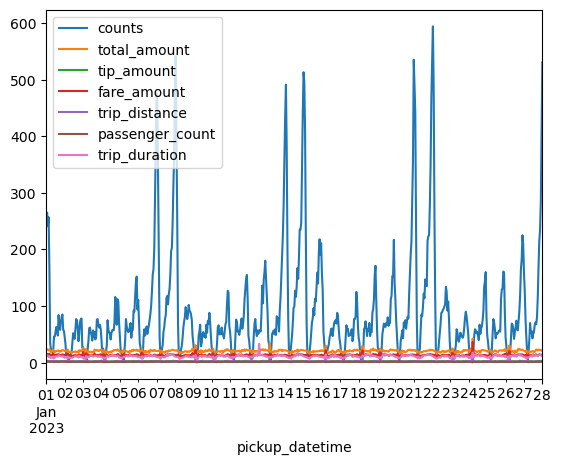

In [7]:
ts_1.plot()
plt.xlim('2023-01-01', '2023-01-28')

As we see, there is `daily seasonality` as there should be high ride activity during the day and low ride activity at night. However, there are weekly patterns. Consider that this is East Village, popular for its clubs and bars. So we expect the area to be more active on weekends at night. This is exactly what we see with the high spikes. This periodic pattern on Fridays, Saturdays, and Sundays is suggestive of `weekly seasonality`. 

### Basic Visualization of Seasonality 
We do this with two methods: the FFT (Fast Fourier Transform) and the ACF (Autocorrelation Function).

In the FFT, peaks will be associated with periodicity. If our time series has a periodicity associated with some frequency, such as $1/24 \ hr^{-1}$, there will be large peaks associated with that frequency and multiples of that frequency (a la Fourier Expansion). You can check that is what we see below. In the ACF, peaks will be associated with seasonality. Unsurprisingly, the main periodicities match.

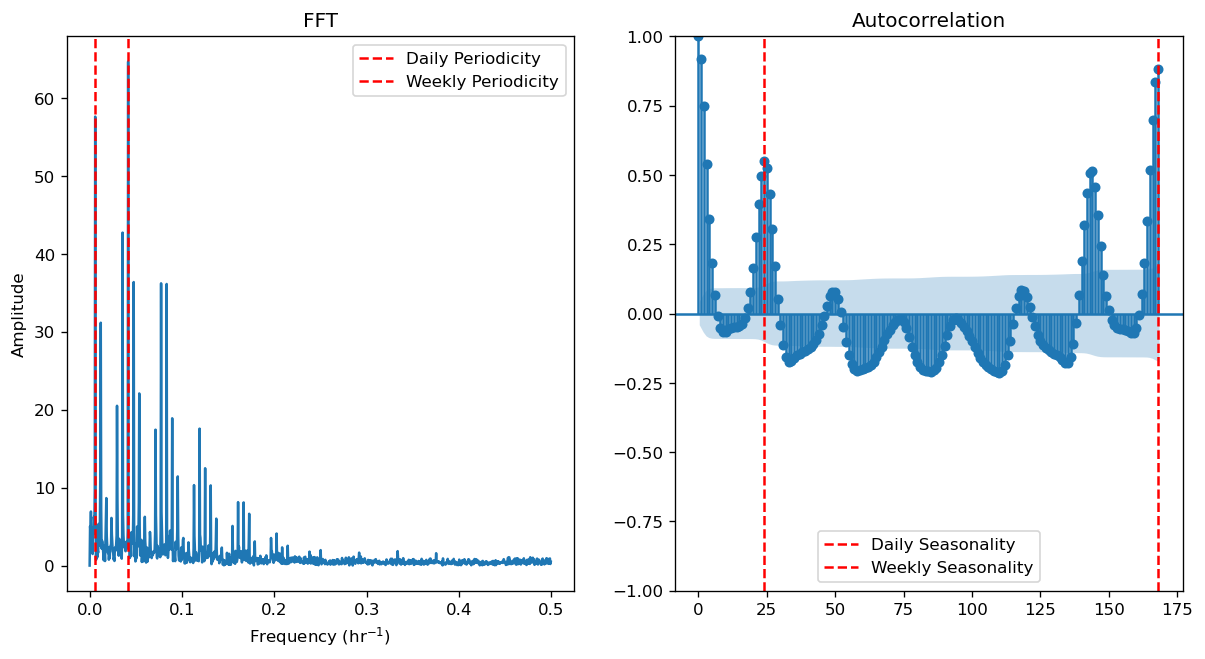

In [8]:
fig, axes = plt.subplots(figsize = (12, 6), dpi = 120, nrows = 1, ncols = 2)

# compute fft
from scipy.fft import fft, fftfreq

N = len(ts_1) # number of samples
T = 1. # sampling interval (one set of counts per hour)
x = np.arange(N) # time axis
y = (ts_1['counts'].values - ts_1['counts'].mean())  # subtract the mean to remove the zeroth-frequency peak
yf = fft(y) # compute the FFT
xf = fftfreq(N, T)[:N//2] # frequency axis

plt.axes(axes[0])
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlabel('Frequency (hr$^{-1}$)')
plt.ylabel('Amplitude')
plt.title('FFT')
plt.axvline(x = 1/24, color = 'red', linestyle = '--', label = 'Daily Periodicity')
plt.axvline(x = 1/(24*7), color = 'red', linestyle = '--', label = 'Weekly Periodicity')
plt.legend()

# compute autocorrelation
from statsmodels.graphics.tsaplots import plot_acf

plt.axes(axes[1])
plot_acf(ts_1['counts'] - ts_1['counts'].mean(), lags = 24*7, ax = axes[1])
plt.axvline(x = 24, color = 'red', linestyle = '--', label = 'Daily Seasonality')
plt.axvline(x = 24*7, color = 'red', linestyle = '--', label = 'Weekly Seasonality')
plt.legend()

### Fitting a Multiseasonal Time Series Model
This isn't obvious and requires some tools that I don't currently understand. First, let's check that difference between subsequent counts is roughly stationary, the ACF, and the PACF.

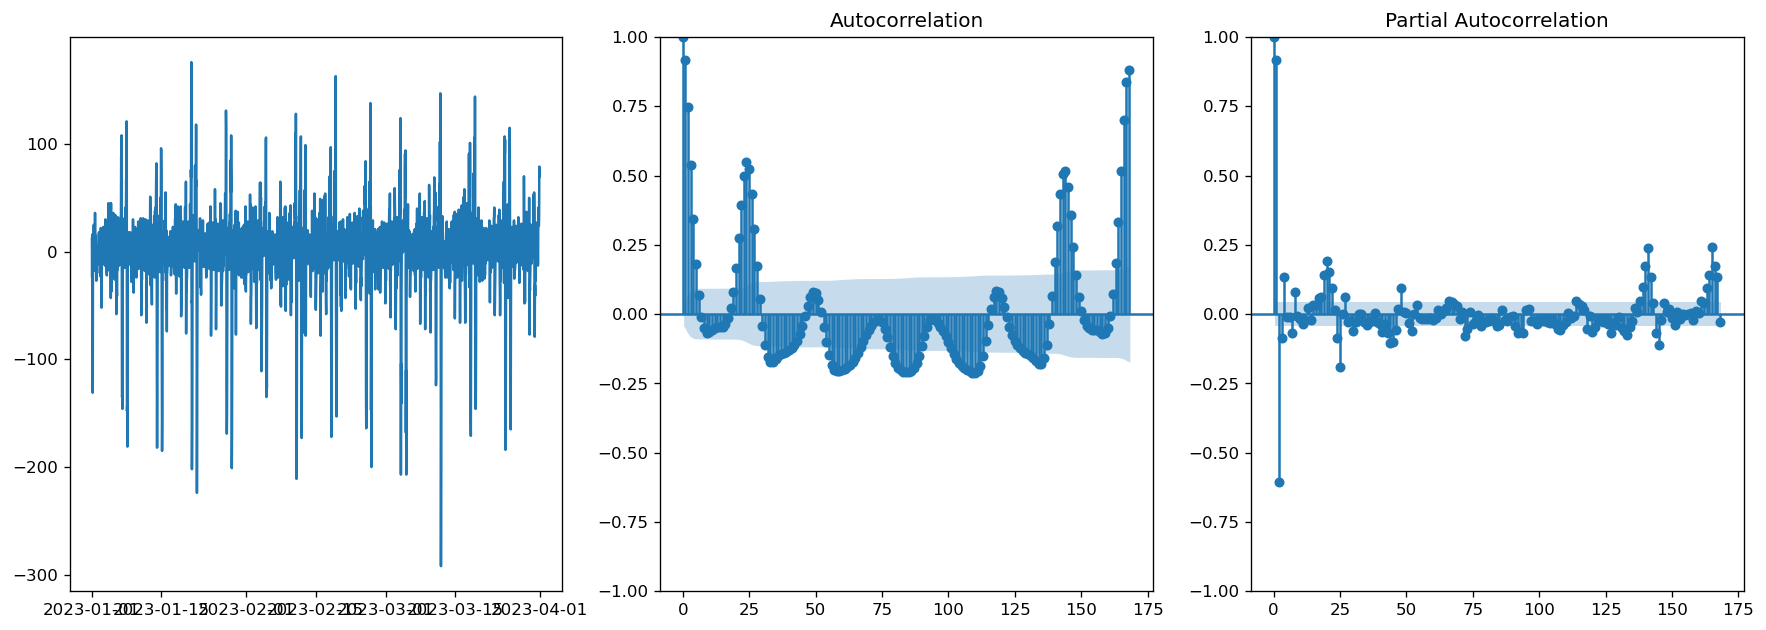

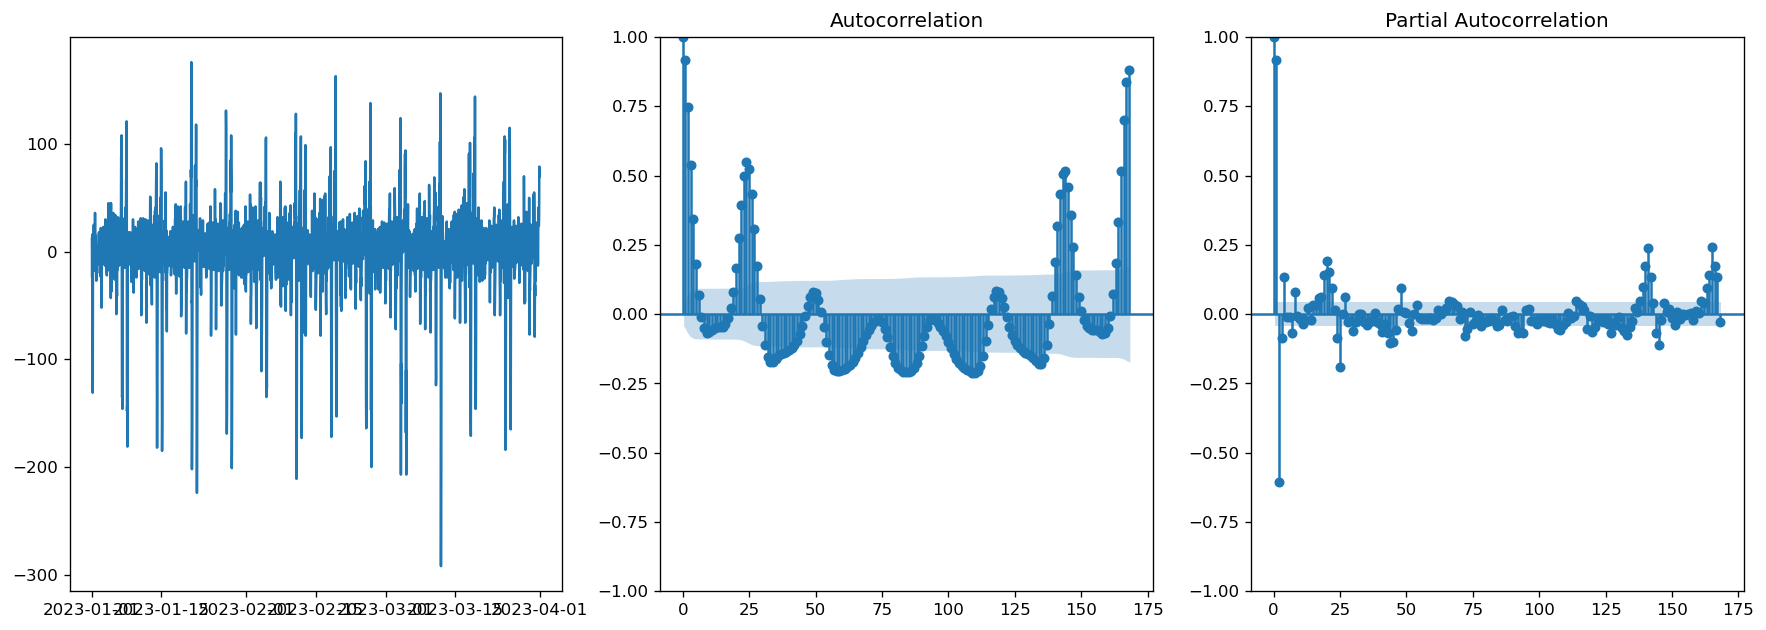

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(figsize = (18, 6), dpi = 120, nrows = 1, ncols = 3)
plt.axes(axes[0])
plt.plot(ts_1['counts'].diff())
plot_acf(ts_1['counts'] - ts_1['counts'].mean(), lags = 24*7, ax = axes[1])
plot_pacf(ts_1['counts'], lags = 24*7, ax = axes[2])

### Summary:
- The difference time series is reasonably stationary
- The ACF warrants a MA model (see SARIMA notebook from Erdos DS Bootcamp)
- The PACF warrants a AR model (see SARIMA notebook from Erdos DS Bootcamp)

This will educate the ARIMAX model that we train below. 

### ARIMAX Model:
ARIMA (and SARIMA) is insufficient for modelling our data because it exhibits seasonality across multiple time scales (e.g., daily, weekly, yearly). Implementing a multi-seasonal ARIMAX model is not obvious. See https://stackoverflow.com/questions/68923679/forecasting-time-series-with-multiple-seasonaliy-by-using-auto-arimasarimax-an for more details too.  The seasonality is accounted for by modelling the underlying trend with a Fourier Expansion for each specified frequency. This is accomplished by incorporating exogenous variables of the Fourier components into the fit. 

Our model will predict $\log$-counts, as this will ensure that predictions are non-negative. However, as we will see, I think this causes the errors to grow exponentially with time.

/tmp/ipykernel_2123/1795756910.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_1['log_counts'] = np.log(1. + ts_1['counts']) # added 1 to avoid log(0)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.88614D-01    |proj g|=  2.56324D-02

At iterate    5    f=  4.88207D-01    |proj g|=  1.65383D-04

At iterate   10    f=  4.88195D-01    |proj g|=  4.05445D-03

At iterate   15    f=  4.87890D-01    |proj g|=  6.69836D-03

At iterate   20    f=  4.86985D-01    |proj g|=  4.80890D-03

At iterate   25    f=  4.86101D-01    |proj g|=  2.68732D-02

At iterate   30    f=  4.85640D-01    |proj g|=  9.89186D-03

At iterate   35    f=  4.84782D-01    |proj g|=  5.27859D-03

At iterate   40    f=  4.84602D-01    |proj g|=  2.22029D-03

At iterate   45    f=  4.84516D-01    |proj g|=  1.58597D-03

At iterate   50    f=  4.84457D-01    |proj g|=  3.56383D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             log_counts   No. Observations:                 1991
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -964.554
Date:                Thu, 22 Aug 2024   AIC                           1975.109
Time:                        13:19:44   BIC                           2103.814
Sample:                    01-01-2023   HQIC                          2022.379
                         - 03-24-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin_1         -0.8073      0.072    -11.230      0.000      -0.948      -0.666
sin_2         -0.4244      0.037    -11.342      0.000      -0.498      -0.351
sin_3          0.0624      0.025      2.447      0.0

/tmp/ipykernel_2123/1795756910.py:41: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=ts_test.index[0], periods=24*7, freq='H')


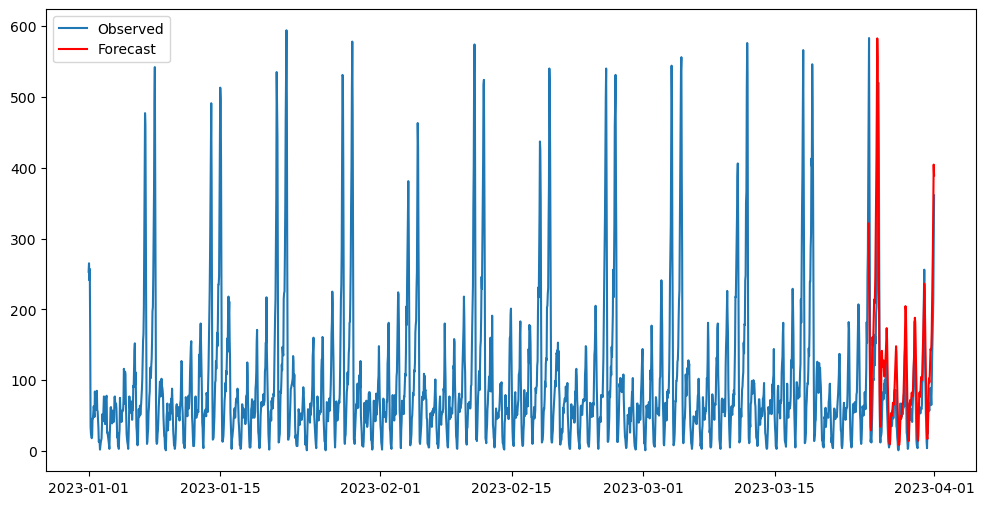

In [10]:
import statsmodels.api as sm

# Example time series data (counts per hour for one week)
# Replace this array with your actual data
ts_1['log_counts'] = np.log(1. + ts_1['counts']) # added 1 to avoid log(0)
ts_data = ts_1['log_counts']

# Split data into training and validation sets
ts_train = ts_1['log_counts'].iloc[:(-24*7)]
ts_test = ts_1['log_counts'].iloc[(-24*7):]

def create_fourier_terms(series, period, K):
    t = np.arange(len(series))
    terms = pd.DataFrame({
        f'sin_{i}': np.sin(2 * np.pi * i * t / period) for i in range(1, K + 1)
    }).join(pd.DataFrame({
        f'cos_{i}': np.cos(2 * np.pi * i * t / period) for i in range(1, K + 1)
    }))
    return terms

# Create Fourier terms for daily (24-hour) and weekly (168-hour) seasonality
periods = [24, 24*7]
fourier_list_train = [create_fourier_terms(ts_data, period=period, K=5)[:(-24*7)] for period in periods] # Kth-order Fourier terms for each period
fourier_list_test = [create_fourier_terms(ts_data, period=period, K=5)[(-24*7):] for period in periods]

# Combine exogenous variables
exog_train = pd.concat(fourier_list_train, axis=1)
exog_train.index = ts_train.index

exog_test = pd.concat(fourier_list_test, axis=1)
exog_test

# Fit SARIMAX model with exogenous variables for multiple seasonalities
sarimax_model = sm.tsa.statespace.SARIMAX(ts_train, order=(1, 1, 1), exog=exog_train).fit()

# Print model summary
print(sarimax_model.summary())

# Forecasting
forecast = sarimax_model.get_forecast(steps=24*7, exog=exog_test)
forecast_index = pd.date_range(start=ts_test.index[0], periods=24*7, freq='H')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(np.exp(ts_data) - 1., label='Observed')
plt.plot(np.exp(forecast_series) - 1., label='Forecast', color='red')
plt.legend()
plt.show()

That's a nice fit and non-negativity is cool too. However, this model has exploding confidence intervals.

<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_2123/473092537.py:12: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log$ Counts')


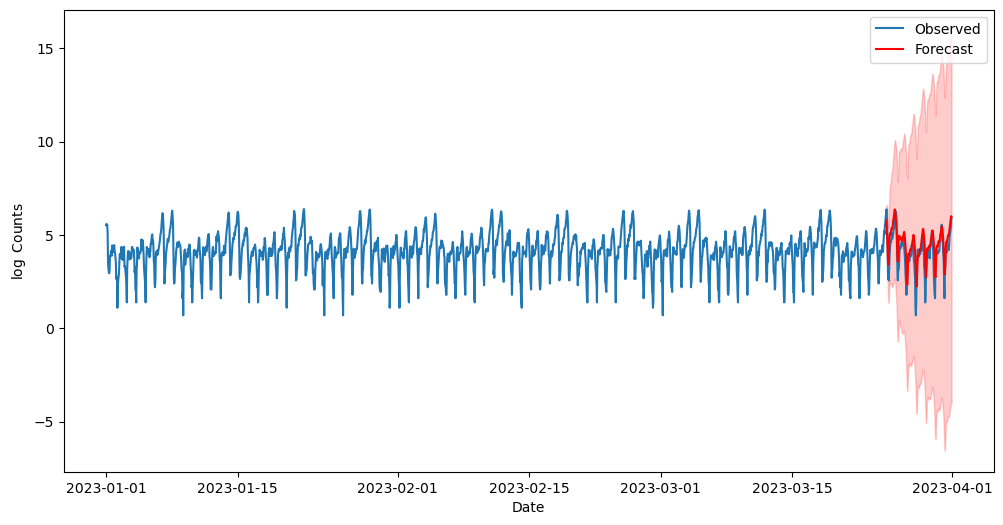

In [11]:
from datetime import timedelta
# Forecasting
preds_df = sarimax_model.get_prediction(start = ts_test.index[0], end = ts_test.index[-1], exog=exog_test).summary_frame(alpha = 0.05)
pred_index = ts_test.index

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(ts_data.index, ts_data, label='Observed')
plt.plot(preds_df.index, preds_df['mean'], label='Forecast', color='red')
plt.fill_between(preds_df.index, preds_df['mean_ci_lower'], preds_df['mean_ci_upper'], color='red', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('$\log$ Counts')
plt.legend()
plt.show()

### Let's compare predictions in-sample

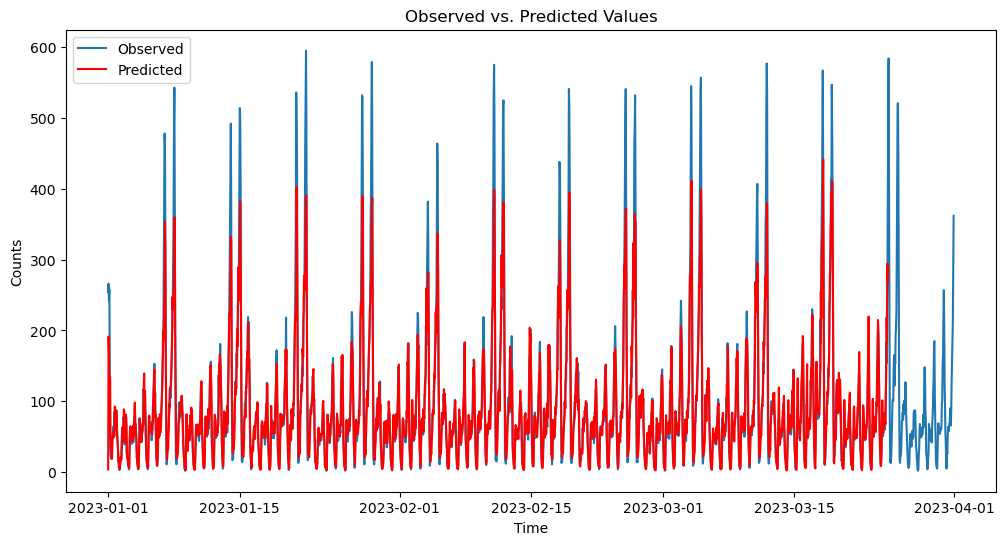

In [12]:
# Generate in-sample predictions
in_sample_predictions = sarimax_model.get_prediction(start= ts_train.index[0], end= ts_train.index[-1], exog=exog_train)
predicted_mean = in_sample_predictions.predicted_mean

# Plot observed vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(np.exp(ts_data), label='Observed')
plt.plot(np.exp(predicted_mean), label='Predicted', color='red')
plt.legend()
plt.title('Observed vs. Predicted Values')
plt.xlabel('Time')
plt.ylabel('Counts')
plt.show()

Not perfect. But, pretty good for a baseline. It might improve if we add more exogenous variables (corresponding to the other peaks in the peaks in the ACF corresponding to 6 days, etc.).

Note, the most important part of this fit is the multi-seasonality. The data has clear multi-seasonal trends that cannot be explained using autoregressive or moving average models alone.